In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from load_data import BatchData
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader, DataListLoader
import IPython.display
import summary

USE_GPU = True
device = torch.device("cuda")

class BasicClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels):
        super(BasicClassifier, self).__init__()

        # Define the GCN layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # Define the final linear layer for classification
        self.fc = torch.nn.Linear(num_edge_features + hidden_channels*2, 1)

    def forward(self, x, edge_index, edge_attr):
        # Apply GCN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        # Pool the node features to obtain edge-level representations
        edge_representations = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_attr], dim=1)

        # Classify the edges using a linear layer and sigmoid activation
        logits = self.fc(edge_representations).squeeze()
        probs = torch.sigmoid(logits)

        return probs


/home/maximus/anaconda3/envs/gnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def displayStats(loader):
        for batch in loader:
            print(batch)
            data = batch  # Get the first graph object.
            print(data)
            print('==============================================================')
            # Gather some statistics about the graph.
            print(f'Number of nodes: {data.num_nodes}')
            print(f'Number of edges: {data.num_edges}')
            print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
            print(f'Number of node features: {data.num_features}')
            print(f'Number of edge features: {data.edge_attr.shape[1]}')
            # print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
            print(f'Has isolated nodes: {data.has_isolated_nodes()}')
            print(f'Has self-loops: {data.has_self_loops()}')
            print(f'Is undirected: {data.is_undirected()}')
            break
        return None

def test_visualise(graph):
    g = torch_geometric.utils.to_networkx(graph, to_undirected=True)
    nx.draw_networkx(g)
    plt.show()
    return None

def getDataDims(loader):
    return [loader.dataset[0].num_features, loader.dataset[0].edge_attr.shape[1]]


In [3]:
def train_model(model, loader, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_history =[]
    for epoch in range(num_epochs):
        for batch in loader:
            if(USE_GPU):
                x           = batch["x"].to("cuda")
                edge_index  = batch["edge_index"].to("cuda")
                edge_attr   = batch["edge_attr"].to("cuda")
                y           = batch["y"].to("cuda")
            probs = model.forward(x, edge_index, edge_attr)
            loss = F.binary_cross_entropy(probs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
        loss_history.append(float(loss.item()))   
        if(epoch%5==0):
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        del loss
        del probs    
        torch.cuda.empty_cache()
    return loss_history

def test(model, loader):
    from sklearn.metrics import roc_auc_score, average_precision_score

    for batch in loader:
        if(USE_GPU):
            x           = batch["x"].to("cuda")
            edge_index  = batch["edge_index"].to("cuda")
            edge_attr   = batch["edge_attr"].to("cuda")
            y           = batch["y"].to("cuda")
        probs = model.forward(x, edge_index, edge_attr)
    y, pred = y.detach().cpu().numpy(), probs.detach().cpu().numpy()

    return roc_auc_score(y, pred), average_precision_score(y, pred)

In [4]:
def init_model(num_node_features, num_edge_features, hidden_channels, loader):
    
    model = BasicClassifier(num_node_features, num_edge_features, hidden_channels)
    # model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    print(summary.summary(model, loader.dataset[0]["x"], loader.dataset[0]["edge_index"], loader.dataset[0]["edge_attr"]))
    return model

In [5]:
## TODO: Change to DataListLoader to allow batches to be subscriptable and possibly add functionality for parallelisation

## TODO: init BatchData with an index range instead to allow 80 20 train-test split


loader_train = DataLoader(BatchData(0,8), batch_size=16, pin_memory=True, num_workers=4)
print("Train Set Batch Count:", len(loader_train))
displayStats(loader=loader_train)
num_nf, num_ef = getDataDims(loader=loader_train)


Loading:
../data/batch_1_0
../data/batch_1_1
../data/batch_1_2
../data/batch_1_3
../data/batch_1_4
../data/batch_1_5
../data/batch_1_6
../data/batch_1_7
Train Set Batch Count: 500
DataBatch(x=[4822, 6], edge_index=[2, 67604], edge_attr=[67604, 4], y=[67604], batch=[4822], ptr=[17])
DataBatch(x=[4822, 6], edge_index=[2, 67604], edge_attr=[67604, 4], y=[67604], batch=[4822], ptr=[17])
Number of nodes: 4822
Number of edges: 67604
Average node degree: 14.02
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [6]:
model = init_model(num_nf, num_ef, 3, loader_train)


+------------------+--------------------------------+----------------+----------+
| Layer            | Input Shape                    | Output Shape   |   #Param |
|------------------+--------------------------------+----------------+----------|
| BasicClassifier  | [350, 6], [2, 8138], [8138, 4] | [8138]         |       56 |
| ├─(conv1)GCNConv | [350, 6], [2, 8138]            | [350, 3]       |       21 |
| ├─(conv2)GCNConv | [350, 3], [2, 8138]            | [350, 3]       |       12 |
| ├─(conv3)GCNConv | [350, 3], [2, 8138]            | [350, 3]       |       12 |
| ├─(fc)Linear     | [8138, 10]                     | [8138, 1]      |       11 |
+------------------+--------------------------------+----------------+----------+


In [ ]:
if(USE_GPU):
    model.to(device = "cuda")
    torch.cuda.empty_cache()

print("Training on GPU:", next(model.parameters()).is_cuda)
loss_hist = train_model(model, loader_train, num_epochs = 100)

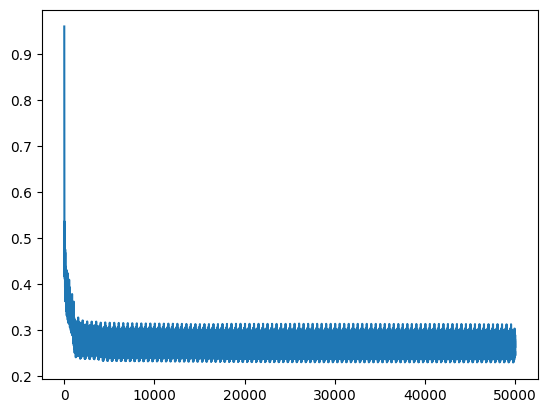

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)
plt.show()


In [ ]:
loader_test = DataLoader(BatchData(8,10), batch_size=16, pin_memory=True, num_workers=4)
print("Test Set Batch Count:", len(loader_train))
displayStats(loader=loader_test)
num_nf, num_ef = getDataDims(loader=loader_test)

Loading:
../data/batch_1_8
../data/batch_1_9
Test Set Batch Count: 500
DataBatch(x=[4587, 6], edge_index=[2, 60020], edge_attr=[60020, 4], y=[60020], batch=[4587], ptr=[17])
DataBatch(x=[4587, 6], edge_index=[2, 60020], edge_attr=[60020, 4], y=[60020], batch=[4587], ptr=[17])
Number of nodes: 4587
Number of edges: 60020
Average node degree: 13.08
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [ ]:
roc_auc, ap = test(model, loader_test)

tensor([0.6523, 0.8582, 0.7114,  ..., 0.9221, 0.9220, 0.9219], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.4198, 0.4197, 0.7342,  ..., 0.8811, 0.8810, 0.8623], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.8439, 0.8436, 0.8441,  ..., 0.9138, 0.9176, 0.9129], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.8408, 0.8411, 0.8933,  ..., 0.8919, 0.8918, 0.8918], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.7913, 0.4349, 0.4351,  ..., 0.9034, 0.9034, 0.9035], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.6304, 0.6307, 0.8029,  ..., 0.9130, 0.9154, 0.8979], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.7813, 0.4552, 0.4561,  ..., 0.9030, 0.9157, 0.9156], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.6618, 0.6619, 0.7102,  ..., 0.8793, 0.9241, 0.9241], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([0.7303, 0.7306, 0.8579,  ..., 0.9103, 0.9105, 0.9104], device='cuda:0',


In [ ]:
roc_auc

0.9084137955318898

In [ ]:
ap

0.7744334191798743